# Graph Analysis For Lead Generation/Targeted Advertising

So far we've managed to collect a lot of Twitter data, explore that data, and eventually create a topic model of tweets in order to sort tweets based on what was being discussed in that particular tweet. Of course, that only takes us so far. We now know which users are talking about a particular topic, but how do we use this data to generate leads or for advertising purposes? 

Well, we have already identified users which write tweets relevant to a topic of our choosing - how do we then take these users and find others with a shared interest? Well, we can take a look at the people who follow those users. With enough data - we can discover which users have the most reach - which users are most "influential" around a topic of our choosing. In this case, we have to define these relationships on a graph.


## Special Note

We don't recommend you use any conclusions from this notebook you may draw for anything but a learning experience. Due to time and accessibility constraints, we're working with a highly truncated data set of Twitter followers/tweets. As such, any conclusions and analysis in this notebook are "correct" within the scope of the dataset we used here - but in reality this analysis is considerably limited. The methodologies used however, could be easily expanded to a larger, more complete, data set from which realistic conclusions can be drawn. 

## Graphs: The Basics

Graph theory can be considered to be the "mathematics of relationships" which allow us to study a range of different tasks. From discovering how people/things are connected and which of those connections is most important/surprising. To finding the shortest pathways from point A to B (that's right, Google maps used a graph to direct you to the workshop today!). Let's go over some of the basics of a graph before we dive into the analysis today. 

### Nodes,  Edges, and Graphs

The most important, and most basic concept of a graph is that they're made of only two things: nodes, and edges. Nodes are the entities, and edges are the relationships between those entities, for example

> ![undirected graph](images/undirected_graph.png)

> **Figure 1**, a small undirected graph. 

In Figure 1 above we have four nodes and four edges. If an edge runs from one node to another node they are said to be _connected_. This connection depicts some relationship between the nodes. In the example above, there is no direction associated with the edges which means that this graph is _undirected_, or that the relationships between nodes are symmetric. 

#### Linear Algebra Digression

As with most things in Data Science, anything intuitively interesting such as graphs are _really_ just linear algebra pretending to be something more exciting. Every graph has what's known as an [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix), or the matrix representation of the connections between nodes. For example, the adjacency matrix $\mathbf{A}$ of the graph above is given by :

$$ \mathbf{A} = 
\begin{pmatrix}
0 & 1 & 1 & 0 \\
1 & 0 & 1 & 1 \\
 1 & 1 & 0 & 0 \\
 0 & 1 & 0 & 0
\end{pmatrix}
$$ 

where the rows and columns are in the order of Node 1, Node 2, Node 3, Node 4. In this case by reading the rows and columns of the adjacency matrix, we can tell which nodes share edges. For example, by reading the first column of $\mathbf{A}$, we see that the first node does not share any edges with itself, however it shares an edge with Node 2 (the second row) and Node 3 (the third row). Also note that for our undirected graph, the adjacency matrix is _symmetric_, namely 

$$
\mathbf{A} = \mathbf{A^T}
$$

meaning that calculations on undirected graphs are quite fast. By utilizing the adjacency matrix, we can harness the power of fast linear algebra routines in order to understand the connections within our graph.



### Back to Nodes, Edges and Graphs
However, graphs can also be _directional_, or that the relationships between nodes may only have a single direction (for example, if someone "follows" someone on Twitter, that is a directional relationship). For example, a typical (small) twitter follower relation may appear as follows on a directional graph 

> ![directed graph](images/directional_graph_followers.png)

> **Figure 2**, a small directional graph which may represent twitter follower relationships. Note that _directed_ graphs are more complex than undirected graphs as our relations are only uni-directional. 

Note how in the graph above, we now have twice the number of edges if two users follow each other.


#### Linear Algebra Digression 

In the case of _directional_ graphs, we have to keep track of our relationships a little differently. This means that for directional graphs, the adjacency matrix is no longer symmetric. In the case of the graph above, the adjacency matrix $\mathbf{A}_2 $ would have the following form

$$
\mathbf{A}_2 =
\begin{pmatrix}
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 1 & 0 & 1 \\
0 & 1 & 0 & 1 & 1 & 0 
\end{pmatrix}
$$

where we're only concerned with edges _leaving_ a particular node. In the case of directional graphs, the transpose of $\mathbf{A}_2$ is known as the _reverse_ graph, and represents the edges _entering_ a particular node. 

### Back to Nodes, Edges and Graphs

Using directional graphs, we can define and understand the relationships between Twitter users. Most importantly, we can understand important ideas such as 

1. Who is following who. 
2. Communities within the network (groups of people following similar content) 
3. Who the "influencers" are in the network 

In this notebook, we will demonstrate using a toy example, how to visualize and calculate the above three properties. 

---

## Data Sets Available

Due to the limitations of the free Twitter API, we've prepared a few data sets for you in advance. Below is a list of the data sets we've prepared that you may choose from 

In [ ]:
# Fresh installs of packages users won't have here (also restart kernel for them )

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import json
import pandas as pd
import time
import networkx as nx
from pyvis import network as net 
from operator import itemgetter
from collections import OrderedDict
import numpy as np
from IPython.display import display, Markdown, Latex
from helpers.color import *

# Getting User Information 

In the previous notebook, we identified users which were tweeting in specific topics. From this, it is clear that these users are interested in our topic of interest based on the content that they typically tweet. Now, we could certainly target those users with our content/advertisements/proposals - however they may not have our desired outreach. Not to mention, there may be too many of them and ideally we'd like to have to deliver our content directly to the fewest number of people possible - while reaching the maximum number of people. To do this task, we first grab a list of each of our identified "topic users" followers. 

**Note: Due to API limitations of free Twitter services, we only gather up to 250 followers for each user**

Our first step is to download the user information that we gathered using [this twitter bot](UserInfoGather.ipynb), which is stored as a JSON (JavaScript Object Notation) object. Let's download it and look at the data that we have available on each Twitter user. In this case, we've downloaded up to 250 followers of each user which had a tweet appear in a given topic more than once. In this way, we can see up two degrees of separation between each of our "influencers" as identified by our topic model. However, we note again that by only gathering up to 250 of each users followers we're presented with a significantly limited data set. 

In [90]:
with open('topic_users_entertainment.json') as json_data:
    followers_dict = json.load(json_data)
    
key = list(followers_dict.keys())[0]
followers_dict[key][0]


{'blocked_by': False,
 'blocking': False,
 'contributors_enabled': False,
 'created_at': 'Mon Sep 30 23:08:28 +0000 2013',
 'default_profile': False,
 'default_profile_image': False,
 'description': '@BTS_twt 👑 #BTSLoveMyself 💜',
 'entities': {'description': {'urls': []},
  'url': {'urls': [{'display_url': 'Instagram.com/dianagi98',
     'expanded_url': 'http://Instagram.com/dianagi98',
     'indices': [0, 23],
     'url': 'https://t.co/SNmG3Ryoqx'}]}},
 'favourites_count': 61210,
 'follow_request_sent': False,
 'followers_count': 405,
 'following': False,
 'friends_count': 759,
 'geo_enabled': False,
 'has_extended_profile': True,
 'id': 1921576484,
 'id_str': '1921576484',
 'is_translation_enabled': False,
 'is_translator': False,
 'lang': 'en',
 'listed_count': 0,
 'live_following': False,
 'location': 'México 🇲🇽',
 'muting': False,
 'name': 'Diana Gi 🎹💜🇲🇽',
 'notifications': False,
 'profile_background_color': '000000',
 'profile_background_image_url': 'http://abs.twimg.com/images/

Where we actually have a lot of information about each user provided. From their profile picture, to their profile customization settings. Essentially what we have is a text description of each users public profile information. 


## Data Format 

In the above data set we have what is known as a `dictionary` where in we can access information based on a named key. In the data set above, our dictionary is formatted as such

```python3
    {
        'User1' : ["UserObject11, UserObject12, ..., UserObject1N],
        'User2' : ["UserObject21, UserObject22, ..., UserObject2N],
        ...
        'UserN' : ["UserObjectN1, UserObjectN2, ..., UserObjectNN]
    }
```
Where the `"UserN"` strings are the screen name of users we identified within our topic model, and the list after the colon is the list of that users followers user JSON object.


## Where do our users reside? 

There's a lot of analysis we could do using this information - however for the most part we are only going to look at user names and follower relations. However, it is also important to take a look at the information each user has provided us in terms of their location. This is done in the cell below. 

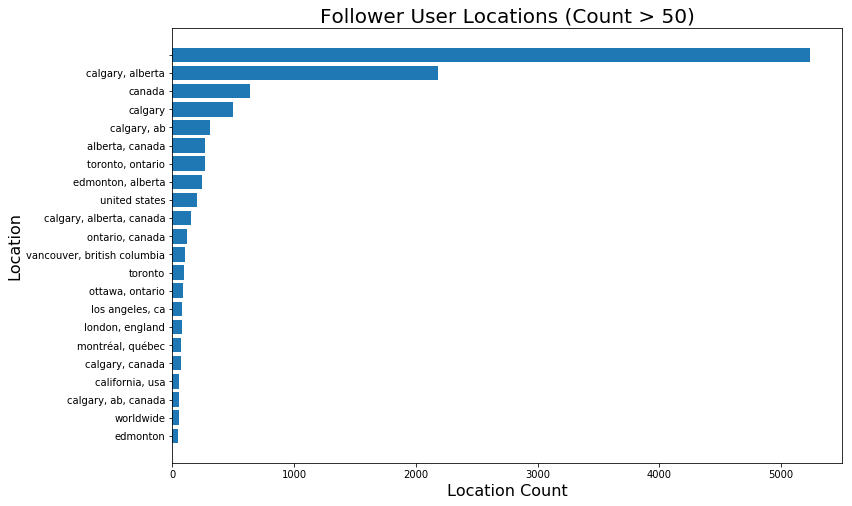

In [91]:
locs = []

for users in followers_dict.keys():
    for follower in followers_dict[users]:
        locs.append(follower['location'].lower())

locations_counted = Counter(locs).most_common()

y = []
x = []
for i in range(len(locations_counted)):
    if locations_counted[i][1] > 50:
        x.append(locations_counted[i][0])
        y.append(locations_counted[i][1])

plt.figure(figsize=(12,8))
plt.barh(x[::-1],y[::-1]) 
plt.xlabel("Location Count", size = 16)
plt.ylabel("Location", size = 16)
plt.title("Follower User Locations (Count > 50)",size = 20)
plt.show()

Where the first bar with no label is the users who have not provided their location to Twitter's public data - and therefore we don't get to know their location. But for the most part these locations make sense - the majority with listed locations are from Alberta, our search box. However, we have other user locations in the above. These are likely the result of either tourists, or someone deciding to tweet from a location they are not currently in, as Twitter provides this functionality. 

# Finding your "Influencers" 

Certainly, we could take the naive approach and simply look for the user in our data set with the most followers like so

In [92]:

follower_count = {}
for users in followers_dict.keys():
    for follower in followers_dict[users]:
        follower_count[follower['screen_name']]  = follower['followers_count']
            
        
power_users = sorted(follower_count.items(), key=itemgetter(1), reverse=True)[:10]
power_users_counts =np.sum([i[1] for i in power_users])


print("Total followers of our top 10 users", power_users_counts)
power_users

Total followers of our top 10 users 23262908


[('DJPaulyD', 3971588),
 ('benlandis', 3404170),
 ('colortheory', 2516865),
 ('DigitalTrends', 2153738),
 ('SiriouslySusan', 2122690),
 ('ShinobiNinja', 1908501),
 ('toddcarey', 1853086),
 ('shwood', 1821115),
 ('MurrayNewlands', 1776167),
 ('CynthiaLIVE', 1734988)]

Where the users above have millions of followers in total. However, an approach like this has some major disadvantages. 


1. If we wanted to run advertising through them, it would likely be expensive
2. If we wanted to target them with advertising, it is probable that they don't use this account for anything but personal tweets/paid advertisement, and they will not re-tweet our content. 
3. It is likely their audiences are _not_ local to Alberta (where we're considering) 
4. Without paying for _a lot_ of data, we have no idea how much overlap of our user base we have - we won't know how many _unique_ people we're reaching between them. 


However, it also has one major advantage:


1. We'd be done our analysis already.


For our purposes however, we'd like to do a couple of things

1. Reach as many users from our data set as possible as we already have a strong reason to believe they're interested in the topic of interest already 
2. Identify the users that are most important to _our_ data set
    * Use these users to reach as many people in the data set as possible
    
In order to do this, we're going to put our data on a graph. To be precise - two graphs to compare analysis. Our first will be a _directed_ graph where the follower-followee relationship is explicitly stated on the graph, and the second will be an _undirected_ graph, where only connections are made specific. Putting our data on the graph is done with the `networkx` graph package of python and done in the cell below. These graphs will allow us to quickly explore the relationships between all of our users and their followers, and use those relationships to derive some insights


In [93]:
network_vis = {}

# Iterate over the users identified in our topic model 
for users in followers_dict.keys():
    # Put their followers 
    user_names = []
    for follower in followers_dict[users]:
        # Only want screen name, not the whole user object 
        user_names.append(follower['screen_name']) 
    network_vis[users] = np.array(user_names)
    
# our directed graph
directed_graph = nx.DiGraph(network_vis)
# our undirected graph 
undirected_graph = nx.Graph(network_vis)

print("Directed graph -- nodes:", directed_graph.number_of_nodes(), "edges:", directed_graph.number_of_edges())
print("Undirected graph -- nodes:", undirected_graph.number_of_nodes(), "edges:", undirected_graph.number_of_edges())

Directed graph -- nodes: 18890 edges: 20485
Undirected graph -- nodes: 18890 edges: 20478


From the above output, the number of nodes represents the number of users in our data set, and the number of edges is the number of relationships between those nodes. Let's get a sense for how connected our graphs are in order to quantify how these nodes are related. First, let's calculate the density of our graphs - a measure of overall connectivity. A density of 1 would imply that our graph is fully connected, and a density of 0 would imply our graph is not at all connected. Density is calculated using the following 

The density for undirected graphs is

$$d = \frac{2m}{n(n-1)},$$
and for directed graphs is

$$d = \frac{m}{n(n-1)},$$
where $n$ is the number of nodes and $m$ is the number of edges in the graph $G$. Note the factor of $2$ in the undirected graph is a result of the edges "going both ways" 



In [94]:
print("Directed graph density", nx.density(directed_graph))
print("Undirected graph density", nx.density(undirected_graph))



Directed graph density 5.741099103365596e-05
Undirected graph density 0.00011478274585181417


Where our graphs are _very_ low density. This is not surprising as we only gathered one degree of separation worth of data (direct followers), and as such we're missing the overall connectivity of many of the user relationships. As our densities are so low - we know that our graph has very few connections meaning there's very few relationships relatively speaking. This implies that in our limited data set - most users only follow one or two other users. 

## Which Nodes Are Most Influential? 

For our analysis there are two different metrics with which we can assess the importance of a given node. The easiest one to understand is the degree of a node; or the number of edges connected to that particular node. 

In the case of directed graphs however, there is two different degree metrics:

1. In degree: The number of edges going into a node
2. Out degree: The number of edges coming out of a node



In [95]:

print("Out Degree, Equivalent to number of followers a user has\n" ,sorted(directed_graph.out_degree(), key=lambda x:x[1], reverse=True)[:5])
print()
print("In Degree, Equivalent to number of people a user follows \n", sorted(directed_graph.in_degree(), key=lambda x:x[1], reverse=True)[:5])
print()
print("Degree, equivalent how many users one is following and followed by\n", sorted(undirected_graph.degree(), key=lambda x:x[1], reverse=True)[:5])


Out Degree, Equivalent to number of followers a user has
 [('Ember_Daily', 250), ('BURNCOLandscape', 250), ('Sexyshorty081', 250), ('CanadianBeats1', 250), ('andr3w2011', 250)]

In Degree, Equivalent to number of people a user follows 
 [('ilovequotebooks', 10), ('PolcanCalgary', 10), ('UCPFails2019', 10), ('ezappliance2', 10), ('waalfloweryyc', 8)]

Degree, equivalent how many users one is following and followed by
 [('TourismCalgary', 253), ('ModernSteakCA', 252), ('JamieGiszas', 252), ('PolicyRachel', 252), ('YMCA_Calgary', 251)]


Once again, we could stop our analysis right here; we've discovered the most connected users in our graph - let's target them! 

Of course, in graph theory quantity does not always imply quality. If we can only target a limited number of users - we want to target users of the highest quality. What we mean by quality in this context is a node that is connected to other nodes which themselves are well connected. Put most simply, an important node is connected to other important nodes.

The question remains: how do we find these important nodes? 

### Eigenvector Centrality 

In order to discover which users are the most well connected to other well connected nodes, we need to introuduce a metric known as **eigenvector centrality**. Here, the eigenvalues and eigenvectors of the graph are calculated using the graph's adjacency matrix $\mathbf{A}$ defined as 

$$ \mathbf{A \;x} = \lambda \mathbf{x} $$

where $\mathbf{x}$ is an eigenvector of $\mathbf{A}$ and $\lambda$ is an eigenvalue. In this case, the centrality of a given node $n_i$ is the $i^{th}$ component of a given eigen vector. However, as in general we'll have $N$ eigenvectors, where $N$ is the number of nodes in our graph, how do we choose the "best" eigenvalue-eigenvector pair? In this case we choose the eigenvector with the largest eigenvalue. In this case, the eigenvalue centrality of a given node is defined as 

$$ x_i = \frac{1}{\lambda^*} \sum_{<i,j>} x_j $$

where the notation $<i,j>$ means that summation is only over connected nodes, and $\lambda^*$ is the largest eigenvalue, and $x_m$ are the components of the associated eigenvector with $\lambda^*$


In [96]:

list(OrderedDict(sorted(nx.eigenvector_centrality(undirected_graph).items(), key=itemgetter(1),reverse=True)).items())[:15]

[('ModernSteakCA', 0.21903325587075573),
 ('DishntheKitchen', 0.2024004296060811),
 ('DustinMorris13', 0.17877639154414465),
 ('Tracey_YYC', 0.17830163894123438),
 ('Newsbob', 0.17516434542114548),
 ('RickTulsie', 0.17252657550113726),
 ('yycfoodjunkie', 0.170970438051077),
 ('villagebrewery', 0.1499217264319529),
 ('designertweets', 0.14308153931632497),
 ('VincentRule', 0.14282740177698874),
 ('WeAreBrewsters', 0.1372980207188305),
 ('ReWorksYYC', 0.13287167327771449),
 ('JamieGiszas', 0.13237716476042283),
 ('GOLDENACRE', 0.11539168292612369),
 ('grahamsucha', 0.10771225143139429)]

In [97]:
# Here we reverse our connections as we want the "in" eigenvector centrality 
list(OrderedDict(sorted(nx.eigenvector_centrality(directed_graph.reverse()).items(), key=itemgetter(1),reverse=True)).items())[:15]

[('RickTulsie', 0.5439354037157313),
 ('VincentRule', 0.3846414810834277),
 ('smileyd2006', 0.3846219660269408),
 ('Tracey_YYC', 0.3846185221934431),
 ('Chinook87', 0.3221177982030675),
 ('KbtKevan', 0.2277716836448645),
 ('johangreg', 0.2277716836448645),
 ('barb_hill', 0.2277716836448645),
 ('CivicTechYYC', 0.015838210475808776),
 ('EWoolleyWard8', 0.015837847967019546),
 ('LowaBeebe', 0.01055881372385137),
 ('PattyMC22', 0.01055881372385137),
 ('ImaginaryWars', 0.009883050939600914),
 ('garseeyaink', 0.009883048361760625),
 ('coldcanadian14', 0.00017920340044328588)]

In [98]:
# Without reverse it is their followers, with reverse it is who they follow

person = 'RickTulsie'
to_reverse = True
if to_reverse:
    ego_graph = nx.ego_graph(directed_graph.reverse(), person, radius=2, undirected=False, center=True)
else:
    ego_graph = nx.ego_graph(directed_graph ,person, radius=2, undirected=False, center=True)
if len(ego_graph.nodes()) > 800:
    print("Too many nodes for reasonable graph:", len(ego_graph.nodes))
    ego_graph = None
   


In [99]:

G = net.Network("500", "900", notebook=True, directed=True)
    

# reversed here for arrow labels        
if to_reverse:
    G.from_nx(ego_graph)
else:
    G.from_nx(ego_graph.reverse())
grad = gradient ('#85C1E9', "#E59866", len(G.nodes))
for i, node in enumerate(G.nodes):
    #node['size'] = degree_dict[node['title']]
    node['color'] = grad[i]
    

for i, edge in enumerate(G.edges):
    edge['title'] = "Follows"


G.show_buttons(filter_=['physics'])
G.repulsion(node_distance=200)
G.prep_notebook()
G.show("example.html")


# Finding The Minimum Number of Users to Contact

Ideally, we would like to reach everyone in our network with a minimum amount of people. However, as our graph has such low densty reaching everyone with only a few users is difficult, especially because there's a good chance some of our original data set may not at all be interested in sports. What we want is to find a connected set of people as they will certainly all be interested in our original topic. From there, we want to find out the minimum number of users we need to reach out to in order to reach as many people in as dense a network as possible. 

In this case, what we want to do is see how many of our central users (influencers) it takes to reach the majority of our graph

In [100]:
centrality_list = list(OrderedDict(sorted(nx.eigenvector_centrality(directed_graph.reverse()).items(), 
                                          key=itemgetter(1),
                                          reverse=True)).keys())

In [101]:
users_reached = []
influencers = []
density = []
from IPython.display import clear_output

for i in range(2,114,2):
    clear_output(wait=True)
    print("Number of influencers", i, "/110")
    nodes = centrality_list[:i]
    influencers.append(i)
    range_of_influence = []
    for node in nodes:
        try:
            # Finds the "out" neighbors so we don't need to reverse
            followers = nx.ego_graph(directed_graph, node, radius=1, undirected=False, center=True).nodes()
        except Exception as e:
            print(e)
            break
        range_of_influence.append(list(followers))
   
    range_of_influence = set([item for sublist in range_of_influence for item in sublist])
    range_of_influence = list(range_of_influence)

    subby = directed_graph.subgraph(range_of_influence)
    density.append(nx.density(subby))
    
    users_reached.append(len(subby.nodes)/len(directed_graph.nodes()) * 100)



Number of influencers 108 /110


<Figure size 432x288 with 0 Axes>

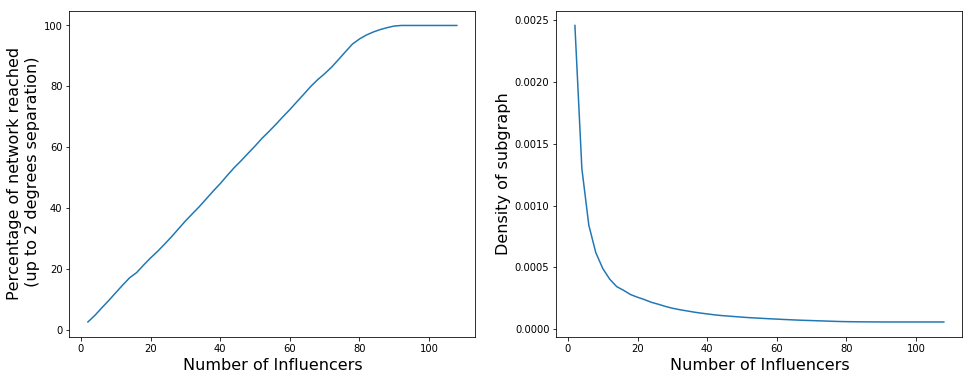

In [102]:
plt.tight_layout()
plt.figure(figsize = (16,6))
plt.subplot(1, 2, 1)

plt.xlabel("Number of Influencers", size=16)
plt.ylabel("Percentage of network reached\n (up to 2 degrees separation)", size = 16)
plt.plot(influencers, users_reached)
plt.subplot(1, 2, 2)


plt.xlabel("Number of Influencers", size=16)
plt.ylabel("Density of subgraph", size = 16)
plt.plot(influencers, density)


plt.show()

Note that this graph is significantly smoother than you would typically expect due to the limited scope of our date collection. In more "realistic" examples, you'd expect to see large jumps in percentage of network reached as you add more and more influencers to your graph, or a more curved growth curve. 

However in the above graph, notice how as we add more influencers - the lower the density of our graph - it is becoming increasingly _disconnected_ as we try to reach a larger portion of our network. As our network represents follower connections between accounts, the more connected the network is implies a greater liklihood that the users have shared interests. For example, our network with 60 influencers has the following structure 



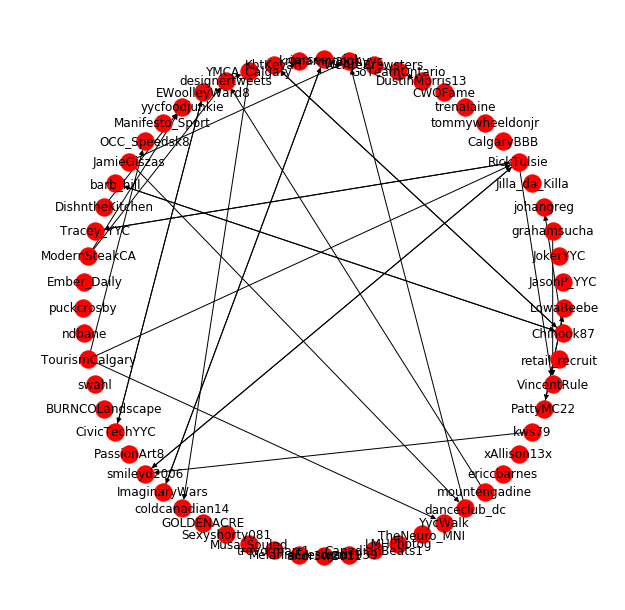

In [115]:
nodes = centrality_list[:60]
test_graph = directed_graph.reverse().subgraph(nodes)
plt.figure(figsize = (8,8))
nx.draw_circular(test_graph, with_labels=True)




Where of our influencers - very few of them share any common connections. Meaning that "influencers" that aren't connected only bring _their_ followers with them, and reaching out to them will not connect to any other parts of our network. As this is the case, we can reduce our network down to our "most connected" influencers by looking at which components are connected any any means. Certianly this is a minimal example - we could in principle look for all pathways between these nodes, however we're simply interested in if it's at all possible to connect our influencers - not how may ways to connect them exist 

In [116]:
# Unfortunately we can only use the undirected network - but we're just looking for _a_ connection 
# and don't really care about the direction in this case .
graphs = list(nx.connected_component_subgraphs(undirected_graph.subgraph(centrality_list[:60])))

good_graphs = []
for graph in graphs:
    # If density is zero, we have a solo node and don't really care about it. 

    if  nx.density(graph) > 0:
        good_graphs.append(list(graph.nodes()))
        
good_graphs=[str(item) for sublist in good_graphs for item in sublist]
G = net.Network("750", "1000", notebook=True, directed=False)
G.from_nx(undirected_graph.subgraph(good_graphs))

# grad = gradient ('#6f2f7B', "#99fbb3", len(G.nodes))
# for i, node in enumerate(G.nodes):
#     node['color'] = grad[i]

G.repulsion(node_distance=200)
G.prep_notebook()
G.show("example3.html")


Where of course, let's compare this method to simply looking at our most influential people according to the eigenvector centrality 

In [117]:
targets = [good_graphs.copy(), centrality_list[:len(good_graphs)]] #user_list #list(graphs[0].nodes())
range_of_influence = targets 
f = []
d = []

for targ in targets:
    range_of_influence = []
    for node in targ:
        try:
            followers =  nx.ego_graph(directed_graph, 
                                      node, 
                                      radius=1, 
                                      undirected=False, 
                                      center=True).nodes()
        except Exception as e:
            break
        range_of_influence.append(list(followers))

    range_of_influence = set([item for sublist in range_of_influence for item in sublist])
    range_of_influence = list(range_of_influence)

    subby = undirected_graph.subgraph(range_of_influence)
    f.append(len(subby.nodes()))
    d.append(nx.density(subby))

print("Number of followers for eigenvector centrality", f[1])
print("Number of followers for most connected influencers", f[0])
print()
print("ratio of followers eigenvector/connected", f[1]/f[0])
print("ratio of density eigenvector/connected", d[1]/d[0])
print("Connected influencer graph densities are", d[0]/nx.density(undirected_graph), "times more dense")
print("Eigencentrality influencer graph densities are", d[1]/nx.density(undirected_graph), "times more dense")

Number of followers for eigenvector centrality 7009
Number of followers for most connected influencers 6798

ratio of followers eigenvector/connected 1.0310385407472786
ratio of density eigenvector/connected 0.9777260723220265
Connected influencer graph densities are 2.8832961321452 times more dense
Eigencentrality influencer graph densities are 2.8190738026236173 times more dense


Where we see that the most important people according to centrality find more people, but the most connected version finds a denser graph. In this particular example, the difference is negligible and there's likely no real advantage to targeting one group over another in this example. However, if you were to expand this data set over a larger, more variable data set where the number of followers for a given user is more variable, a denser network will be more effective for outreach as you will reach "higher quality" users as the more connected they are to multiple influencers or their followers, the more likely it is they're interested in similar things